# **Notebook 02: Modeling Calories Burned**

![alt text](..\Utils\img.webp)

## **Problem Statement:**

#### > Can we predict the number of calories lossed during a workout?

## **Data:**

#### > Calorie data obtained from the *Predict Calorie Expenditure* Kaggle Competition https://www.kaggle.com/competitions/playground-series-s5e5/overview

## **Overview:**
**1. Import Packages**    
**2. Load Stratified Train and Test Data**   
**3. Preprocess Data**
* 3.1 Build Pipeline
    * Feature Engineering
        * Body Mass Index (BMI)
        * Basal Metabolic Rate (BMR)
        * Original Features (Age)
        * Polynomial Features/ Interactions 
            * Duration Heart_Rate
            * Duration^2 
            * Duration Body_Temp 
            * Heart_Rate Body_Temp 
            * Heart_Rate^2 
            * Body_Temp^2 
    * Feature Scaling
    * Regression Modeling

**4. Regression Modeling**
* 4.1 Baseline Models
    * Define Models (tree based models to avoid multicollinearity challenges)
        * Decision Tree Regressor
        * Random Forest Regressor
        * XGBoost
        * Catboost
* 4.2 Model Selection
* 4.3 Hyperparameter Tuning
* 4.4 Learning Curve Analysis: Bias/Variance Tradeoff
* 4.5 Final Model
* 4.6 Evaluate Model Performance
* 4.7 Kaggle Predictions

**5. Save and Document Model**
* 5.1 Save the Final Pipeline
* 5.2 Document:
    * Best hyperparameters
    * Model Type
    * Evaluation Metrics
    * Preprocessing steps

### **1. Import Packages**

In [ ]:
# Import packages

# === Standard Library ===
import json

# === Data Manipulation ===
import pandas as pd 
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt

# === Preprocessing & Feature Engineering ===
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# === Feature Engineering ===
#from sklearn.base import BaseEstimator, TransformerMixin
from Utils.feature_engineering import FeatureEngineering

# === Model Selection ===
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)

# === Evaluation Metrics ===
from sklearn.metrics import mean_squared_log_error, make_scorer

# === Regression Models ===
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# === Model Persistence ===
import joblib

### **2. Load Stratified Train and Test Data**

In [2]:
# === Load data === 
train_path = "strat_train_set.csv"
test_path = "strat_test_set.csv"

strat_train_set = pd.read_csv(train_path)
strat_test_set = pd.read_csv(test_path)

# === Basic Info ===
num_train_instances = strat_train_set.shape[0]
print(f"Training set loaded with {num_train_instances:,} rows and {strat_train_set.shape[1]} columns.")
strat_train_set.head()

Training set loaded with 585,749 rows and 8 columns.


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,female,63,164.0,63.0,20.0,98.0,40.5,118.0
1,female,73,171.0,73.0,11.0,90.0,39.9,55.0
2,female,21,158.0,62.0,3.0,94.0,39.0,16.0
3,male,27,190.0,88.0,2.0,85.0,38.3,7.0
4,female,68,174.0,65.0,14.0,96.0,40.4,79.0


In [3]:
# Separation of features and target
X_train = strat_train_set.drop("Calories", axis=1)
y_train = strat_train_set["Calories"]

X_test = strat_test_set.drop("Calories", axis=1)
y_test = strat_test_set["Calories"]

### **3. Preprocess Data**

#### **3.1 Build Pipeline**

In [4]:
# Create pipeline 
def build_pipeline(model):
    # Pipeline to create features, scale, and apply model
    pipeline = Pipeline([
    ("feature_engineering", FeatureEngineering()),
    ("scaler", StandardScaler()),
    ("model", model)
    ])
    return pipeline

### **4. Regression Modeling**

#### **4.1 Baseline Models**

In [5]:
# Create Baseline Models
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, n_jobs=-1, verbosity=0),
    "CatBoost": CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
}

# Define RMSLE scorer
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Build and evaluate pipelines
pipelines = {name: build_pipeline(model) for name, model in models.items()}

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmsle_scorer)
    print(f"{name}: Mean RMSLE = {-scores.mean():.4f} (± {scores.std():.4f})")

Decision Tree: Mean RMSLE = 0.1447 (± 0.0006)
Random Forest: Mean RMSLE = 0.0620 (± 0.0005)
XGBoost: Mean RMSLE = 0.0893 (± 0.0017)
CatBoost: Mean RMSLE = 0.0724 (± 0.0009)


#### **4.2 Model Selection**


RandomForest is the best performing model as it has the lowest RMSLE score (.0620). However, we will model with CatBoost because it has the second lowest RMSLE (.0724) and will enable us to leverage the power of gpu.

#### **4.3 Hyperparameter Tuning**

In [10]:
# Define the model with GPU support
catboost_gpu_model = CatBoostRegressor(
    task_type="GPU",
    devices="0",
    verbose=2,
    random_seed=42
)

# Create Pipeline
pipeline = build_pipeline(catboost_gpu_model)

# Define param grid
catboost_param_grid = {
    "model__iterations": [2500, 3000],
    "model__depth": [12, 14],
    "model__learning_rate": [0.05],
    "model__l2_leaf_reg": [5],
    "model__border_count": [256],
}

# Apply Grid Search
catboost_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=catboost_param_grid,
    cv=3,
    scoring=rmsle_scorer,
    verbose=2,
    n_jobs=1
)

# Fit Model
catboost_grid_search.fit(X_train, y_train)

# Retreive Best Model
best_catboost_model = catboost_grid_search.best_estimator_
print("Best CatBoost Parameters:", catboost_grid_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 58.8030266	total: 82.8ms	remaining: 3m 27s
2:	learn: 53.2306810	total: 104ms	remaining: 1m 26s
4:	learn: 48.2044987	total: 125ms	remaining: 1m 2s
6:	learn: 43.6702040	total: 146ms	remaining: 52.1s
8:	learn: 39.5779578	total: 168ms	remaining: 46.5s
10:	learn: 35.8685655	total: 189ms	remaining: 42.8s
12:	learn: 32.5352887	total: 210ms	remaining: 40.2s
14:	learn: 29.5113768	total: 231ms	remaining: 38.3s
16:	learn: 26.7870168	total: 253ms	remaining: 36.9s
18:	learn: 24.3345551	total: 274ms	remaining: 35.8s
20:	learn: 22.1250045	total: 298ms	remaining: 35.2s
22:	learn: 20.1296798	total: 320ms	remaining: 34.4s
24:	learn: 18.3345242	total: 341ms	remaining: 33.8s
26:	learn: 16.7150207	total: 362ms	remaining: 33.1s
28:	learn: 15.2584107	total: 385ms	remaining: 32.8s
30:	learn: 13.9497964	total: 407ms	remaining: 32.4s
32:	learn: 12.7774569	total: 428ms	remaining: 32s
34:	learn: 11.7232118	total: 449ms	remaining: 31.6s
36:	lear

In [ ]:
# Train Error
y_train_pred = catboost_grid_search.best_estimator_.predict(X_train)
train_rmsle = rmsle(y_train, y_train_pred)
print(f"Train RMSLE: {train_rmsle:.4f}")

Train RMSLE: 0.0534


#### **4.4 Assess Bias/Variance Tradeoff**

[learning_curve] Training set sizes: [ 39049  78099 117149 156199 195249 234299 273349 312399 351449 390499]


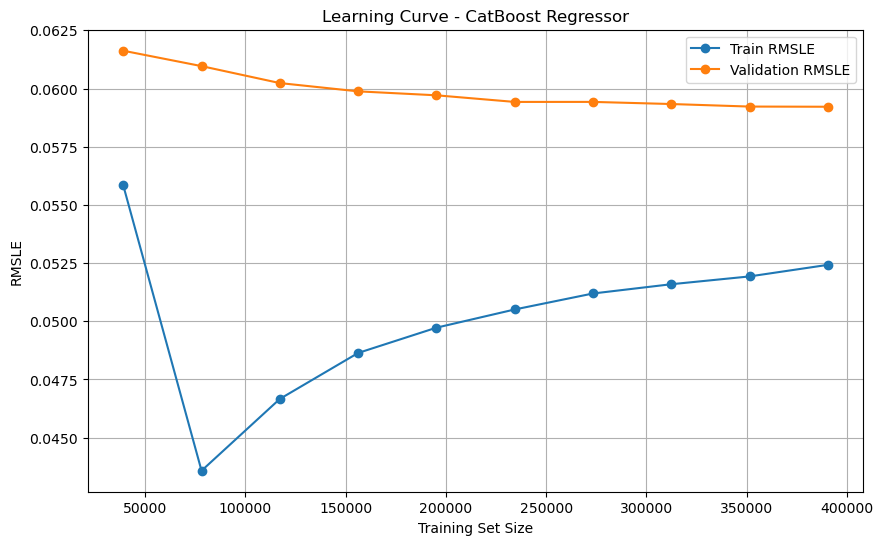

In [12]:
# Clean best params from GridSearchCV keys
best_params = catboost_grid_search.best_params_
clean_params = {k.replace("model__", ""): v for k, v in best_params.items()}

# Instantiate CatBoost with GPU and best params
best_catboost_model = CatBoostRegressor(
    task_type="GPU",
    devices="0",
    verbose=0,
    random_seed=42,
    **clean_params
)

# Build pipeline using your function
learning_curve_pipeline = build_pipeline(best_catboost_model)

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=learning_curve_pipeline,
    X=X_train,
    y=y_train,
    scoring=rmsle_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    shuffle=True,
    random_state=42,
    n_jobs=1,
    verbose=1
)

# Convert scores back to positive RMSLE
train_rmsle = -np.mean(train_scores, axis=1)
val_rmsle = -np.mean(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmsle, "o-", label="Train RMSLE")
plt.plot(train_sizes, val_rmsle, "o-", label="Validation RMSLE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSLE")
plt.title("Learning Curve - CatBoost Regressor")
plt.legend()
plt.grid(True)
plt.show()

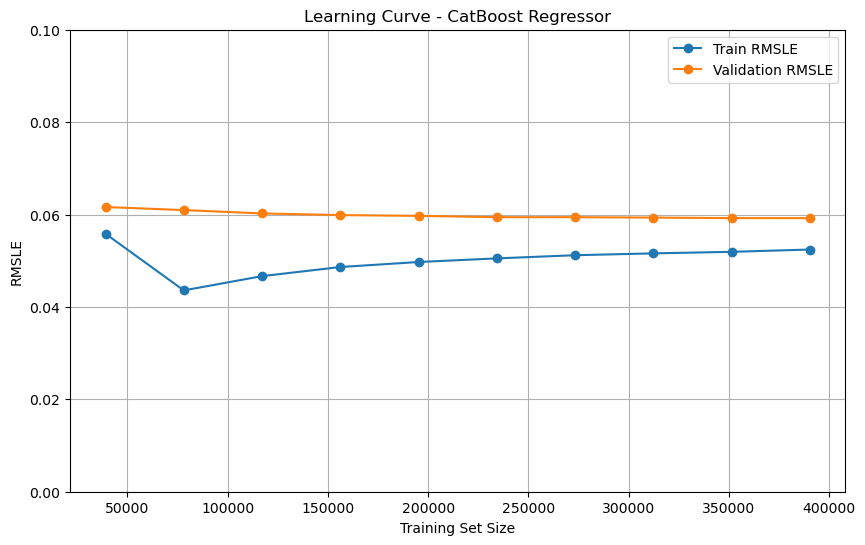

In [14]:
# Zoomed Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmsle, "o-", label="Train RMSLE")
plt.plot(train_sizes, val_rmsle, "o-", label="Validation RMSLE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSLE")
plt.ylim(0,.10)
plt.title("Learning Curve - CatBoost Regressor")
plt.legend()
plt.grid(True)
plt.show()

#### **4.5 Final Model**

In [8]:
# Split X_train into training and validation for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Extract best hyperparameters and prepare CatBoost config
cb_params = {k.replace("model__", ""): v for k, v in best_params.items()}
cb_params["task_type"] = "GPU"
cb_params["devices"] = "0"
cb_params["verbose"] = 100  

# Build preprocessing pipeline (without model)
preprocessing_pipeline = Pipeline([
    ("feature_eng", FeatureEngineering()),
    ("scaler", StandardScaler())  
])

# Fit on training subset
X_train_sub_processed = preprocessing_pipeline.fit_transform(X_train_sub)

# Transform validation set with same pipeline
X_val_processed = preprocessing_pipeline.transform(X_val)

# Initialize CatBoostRegressor with early stopping
final_catboost = CatBoostRegressor(**cb_params)

# Fit CatBoost with early stopping using the processed data
final_catboost.fit(
    X_train_sub_processed,
    y_train_sub,
    eval_set=(X_val_processed, y_val),
    early_stopping_rounds=50
)

# Create Final Pipeline
final_pipeline = make_pipeline(preprocessing_pipeline, final_catboost)

0:	learn: 58.7497459	test: 58.7831374	best: 58.7831374 (0)	total: 27.7ms	remaining: 1m 9s
100:	learn: 3.8395288	test: 3.7949303	best: 3.7949303 (100)	total: 1.24s	remaining: 29.4s
200:	learn: 3.6593543	test: 3.6475668	best: 3.6475668 (200)	total: 2.57s	remaining: 29.4s
300:	learn: 3.5981471	test: 3.6190551	best: 3.6190551 (300)	total: 3.89s	remaining: 28.4s
400:	learn: 3.5529115	test: 3.6019400	best: 3.6019400 (400)	total: 5.18s	remaining: 27.1s
500:	learn: 3.5129841	test: 3.5940333	best: 3.5940333 (500)	total: 6.5s	remaining: 25.9s
600:	learn: 3.4780600	test: 3.5878486	best: 3.5877884 (599)	total: 7.79s	remaining: 24.6s
700:	learn: 3.4456467	test: 3.5847093	best: 3.5846511 (697)	total: 9.08s	remaining: 23.3s
800:	learn: 3.4172656	test: 3.5831622	best: 3.5830225 (799)	total: 10.4s	remaining: 22s
bestTest = 3.582328617
bestIteration = 825
Shrink model to first 826 iterations.


#### **4.6 Evaluate Model Performance**

In [9]:
# Predict on training subset
y_train_pred = final_pipeline.predict(X_train_sub)

# Calculate RMSE
rmsle_train = rmsle(y_train_sub, y_train_pred)
print(f"Train RMSLE: {rmsle_train:.4f}")

Train RMSLE: 0.0567


In [10]:
y_pred = final_pipeline.predict(X_test)
test_rmsle = rmsle(y_test, y_pred)
print(f"Test RMSLE: {test_rmsle:.4f}")

Test RMSLE: 0.0587


#### **4.5 Kaggle Predictions**

In [11]:
# Load Kaggle test cases
kaggle_test = pd.read_csv("../Data/test.csv")

# Generate predictions
kaggle_pred = final_pipeline.predict(kaggle_test) 
submission = pd.DataFrame({"id": kaggle_test["id"],
                           "Calories": kaggle_pred})

# Save file
submission.to_csv("submission.csv", index=False)

### **5. Save and Document Model**

#### **5.1 Save Final Model**

In [12]:
# Save the final pipeline (preprocessing + CatBoost model)
joblib.dump(final_pipeline, "../Model/final_pipeline.pkl")

['../Model/final_pipeline.pkl']

#### **5.2 Document Final Model**

In [13]:
report_data = {
    "model_type": "CatBoostRegressor",
    "best_hyperparameters": best_params,
    "evaluation_metrics": {
        "train_rmsle": rmsle_train,
        "test_rmsle": test_rmsle
    },
    "preprocessing_steps": ["FeatureEngineering", "StandardScaler"]
}

with open("../Model Performance/model_report.json", "w") as f:
    json.dump(report_data, f, indent=4)